In [41]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# 2.3 Probability Analysis (31 points)
- **Threshold-based probability estimation (10 points)**
- **Cross tabulation analysis (6 points)**
- **Conditional probability analysis (10 points)**
- **Summary of observations from each task (5 points)**

In [42]:
# Threshold-based probability estimation

# To not run the preprocessing again we will load the data from the csv:
df_summed = pd.read_csv('cleaned_solar_power_data.csv', parse_dates=['DATE_TIME'])

threshold = 90000  # Example threshold for Total_AC power

# Function to calculate the probability of exceeding the threshold
def threshold_probability(df, column, threshold):
    count_exceeding = (df[column] > threshold).sum()
    total_count = len(df[column])
    probability = count_exceeding / total_count
    return probability

# Calculate the probability for Total_AC power
probability_total_ac = threshold_probability(df_summed, 'Total_AC', threshold)

# Print the result
print(f"Probability of Total_AC exceeding {threshold}: {probability_total_ac:.2f}")

Probability of Total_AC exceeding 90000: 0.34


   IRRADIATION Irradiation_Level
0          0.0              Zero
1          0.0              Zero
2          0.0              Zero
3          0.0              Zero
4          0.0              Zero
Total_AC           False  True 
Irradiation_Level              
Zero                1393      0
Very Low             541      0
Low                  146    169
Medium                 0    384
High                   0    304
Very High              0    197


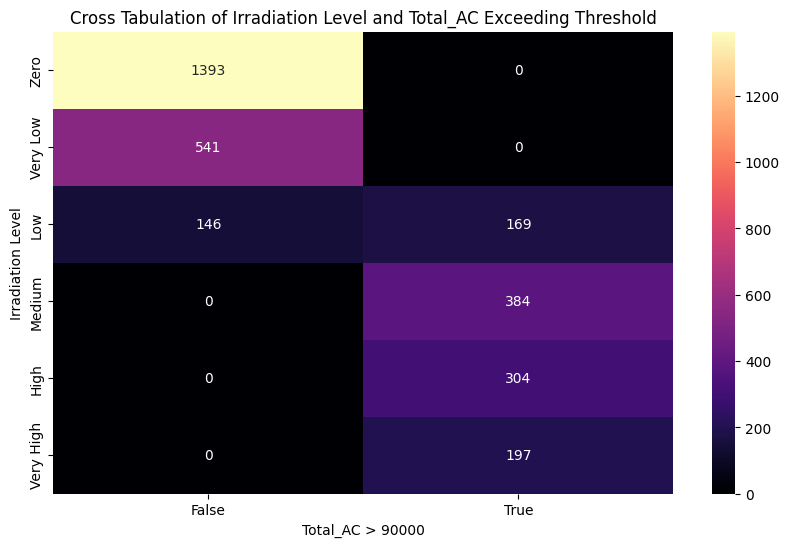

In [ ]:
# Cross tabulation analysis
# Create categorical variable for IRRADIATION
df_summed['Irradiation_Level'] = pd.cut(df_summed['IRRADIATION'], bins=[-1.0, 0.0, 0.2, 0.4, 0.6, 0.8, 1], labels=['Zero', 'Very Low', 'Low', 'Medium', 'High', 'Very High'])
print(df_summed[['IRRADIATION', 'Irradiation_Level']].head())

# Perform cross tabulation between Irradiation_Level and Total_AC exceeding the threshold
cross_tab = pd.crosstab(df_summed['Irradiation_Level'], df_summed['Total_AC'] > threshold)

# Print the cross tabulation table
print(cross_tab)

# Plotting the cross tabulation as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='magma')
plt.title('Cross Tabulation of Irradiation Level and Total_AC Exceeding Threshold')
plt.xlabel(f"Total_AC > {threshold}")
plt.ylabel('Irradiation Level')
plt.show()

Probability of Total_AC > 90000 given Irradiation Level Zero: 0.00
Probability of Total_AC > 90000 given Irradiation Level Very Low: 0.00
Probability of Total_AC > 90000 given Irradiation Level Low: 0.54
Probability of Total_AC > 90000 given Irradiation Level Medium: 1.00
Probability of Total_AC > 90000 given Irradiation Level High: 1.00
Probability of Total_AC > 90000 given Irradiation Level Very High: 1.00


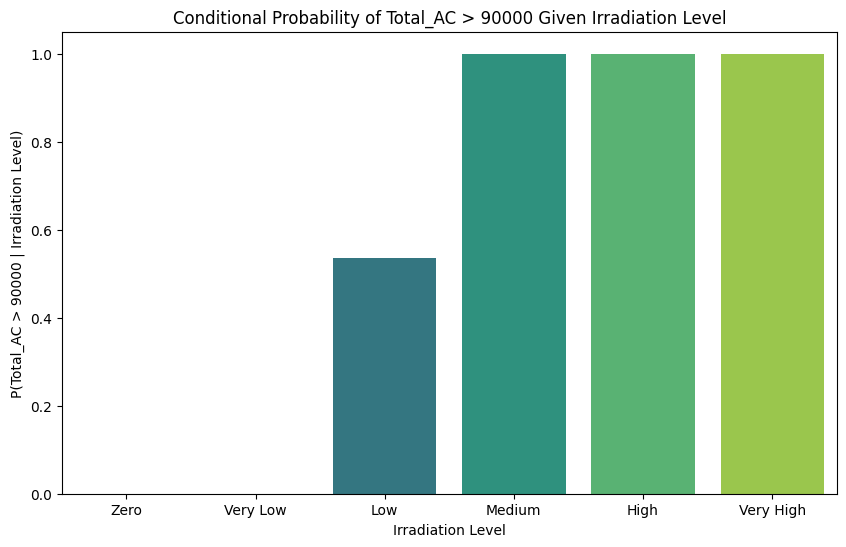

In [ ]:
# Conditional probability analysis
# Function to calculate conditional probabilities
def conditional_probability_analysis(df, condition_col, target_col, threshold):
    conditional_probabilities = {}
    for level in df[condition_col].unique():
        if pd.isna(level):
            continue
        subset = df[df[condition_col] == level]
        p_b = len(subset) / len(df)
        p_a_and_b = len(subset[subset[target_col] > threshold]) / len(df)
        p_a_given_b = p_a_and_b / p_b
        conditional_probabilities[level] = p_a_given_b

    return conditional_probabilities

# Calculate the conditional probabilities for Total_AC exceeding the threshold given Irradiation_Level
conditional_probabilities = conditional_probability_analysis(df_summed, 'Irradiation_Level', 'Total_AC', threshold)

# Print the conditional probabilities
for level, prob in conditional_probabilities.items():
    print(f"Probability of Total_AC > {threshold} given Irradiation Level {level}: {prob:.2f}")

    # Prepare data for plotting
plot_data = pd.DataFrame({
    'Irradiation_Level': list(conditional_probabilities.keys()),
    'Conditional_Probability': list(conditional_probabilities.values())
})

# Plotting the conditional probabilities
plt.figure(figsize=(10, 6))
sns.barplot(data=plot_data, x='Irradiation_Level', y='Conditional_Probability', palette='viridis', hue='Irradiation_Level', dodge=False, legend=False)
plt.title(f'Conditional Probability of Total_AC > {threshold} Given Irradiation Level')
plt.xlabel('Irradiation Level')
plt.ylabel(f'P(Total_AC > {threshold} | Irradiation Level)')
plt.show()

## Summary of Observations

- The probability of Total_AC exceeding the threshold value of 120,000 is approximately 0.15.
    - This value changes: the higher the threshold, the lower the probability.

- The cross tabulation analysis shows the distribution of Total_AC exceeding the threshold across different levels of Irradiation.
    - Depending on the set threshold level, the distribution changes. When set to a higher Total_AC, the more likely it is with a higher irradiation level to be over the threshold.

- The conditional probability analysis reveals the likelihood of Total_AC exceeding the threshold given different Irradiation levels.
    - For this analysis, only the probabilities around the threshold have a probability not to be 1 or 0. Higher levels have a probability of 1, and lower levels have a probability of 0.

# 2.4 Statistical Theory Applications (35 points)
- **Law of Large Numbers demonstration (10 points)**
- **Central Limit Theorem application (20 points)**
- **Result interpretation (5 points)**

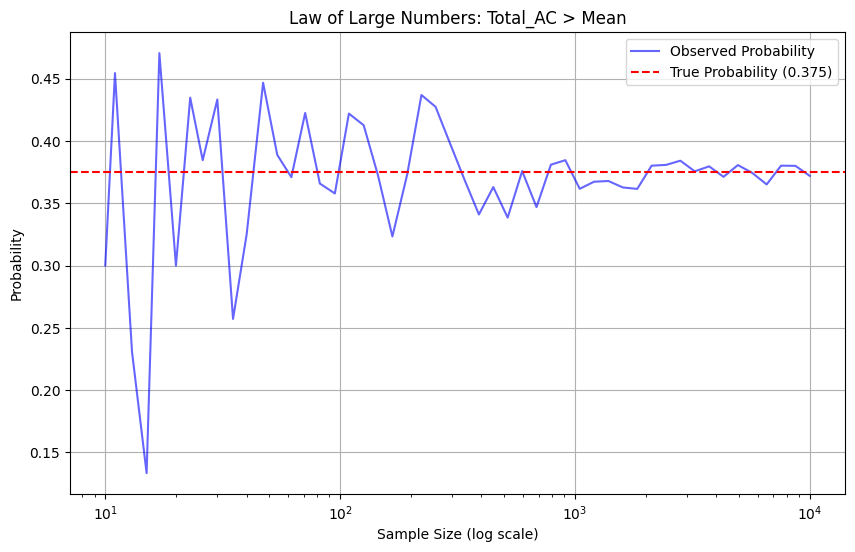

In [ ]:
def visualize_law_of_large_numbers(data, column, threshold_type='mean'):
    """
    Visualize Law of Large Numbers using sensor data
    
    Parameters:
    data : pd.DataFrame - sensor data
    column : str - column name to analyze
    threshold_type : str - 'mean' or 'fixed' for threshold type
    """
    # Set up the threshold
    if threshold_type == 'mean':
        threshold = data[column].mean()
        event_name = f'{column} > Mean'
    else:
        threshold = 25  # Fixed threshold, adjust as needed
        event_name = f'{column} > 25'

    # Calculate true probability
    true_prob = np.mean(data[column] > threshold)

    # Simulate increasing sample sizes
    sample_sizes = np.logspace(1, 4, 50).astype(int)  # 10 to 10000
    observed_probs = []

    for n in sample_sizes:
        sample = data[column].sample(n=n, replace=True)
        observed_prob = np.mean(sample > threshold)
        observed_probs.append(observed_prob)

    # Create main plot
    plt.figure(figsize=(10, 6))

    # Plot: Convergence over sample size
    plt.plot(sample_sizes, observed_probs, 'b-', alpha=0.6, label='Observed Probability')
    plt.axhline(y=true_prob, color='r', linestyle='--', label=f'True Probability ({true_prob:.3f})')
    plt.xscale('log')
    plt.xlabel('Sample Size (log scale)')
    plt.ylabel('Probability')
    plt.title(f'Law of Large Numbers: {event_name}')
    plt.grid(True)
    plt.legend()
    plt.show()

# Load your data
# Assuming df_summed is already defined and contains the necessary columns

# Visualize Law of Large Numbers for the 'Total_AC' column
visualize_law_of_large_numbers(df_summed, 'Total_AC', threshold_type='mean')

Sampling Distribution Statistics:
Mean of sample means: 65558.381
Population mean: 66060.421

Std of sample means: 15554.870
Expected std (σ/√n): 15307.887


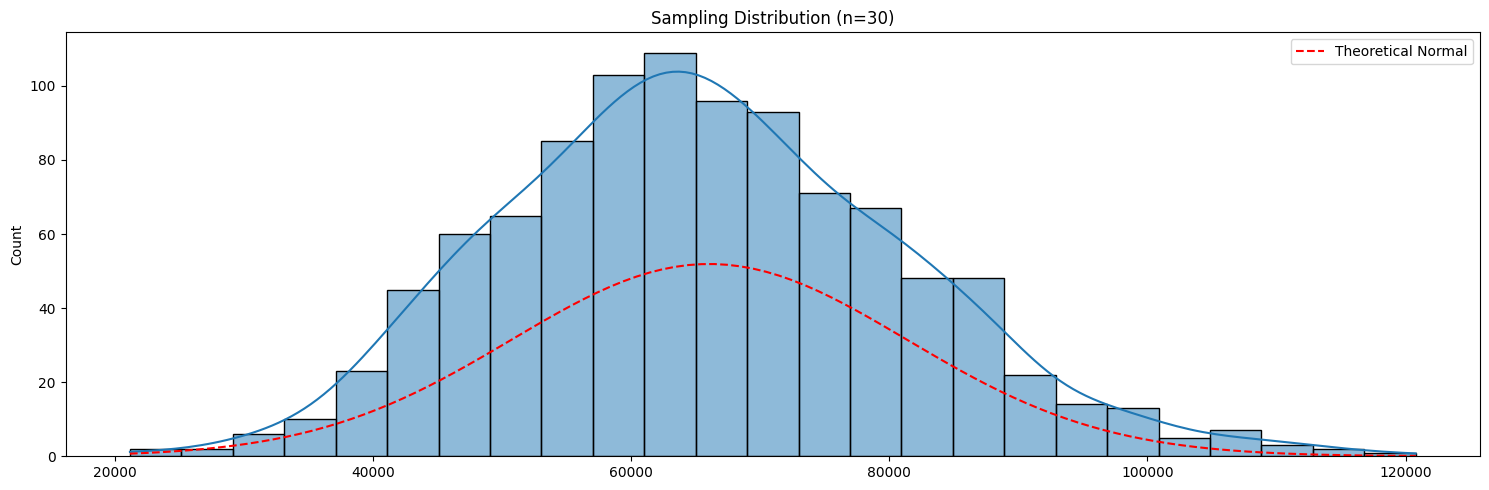

Sampling Distribution Statistics:
Mean of sample means: 66005.783
Population mean: 66060.421

Std of sample means: 8408.002
Expected std (σ/√n): 8384.475


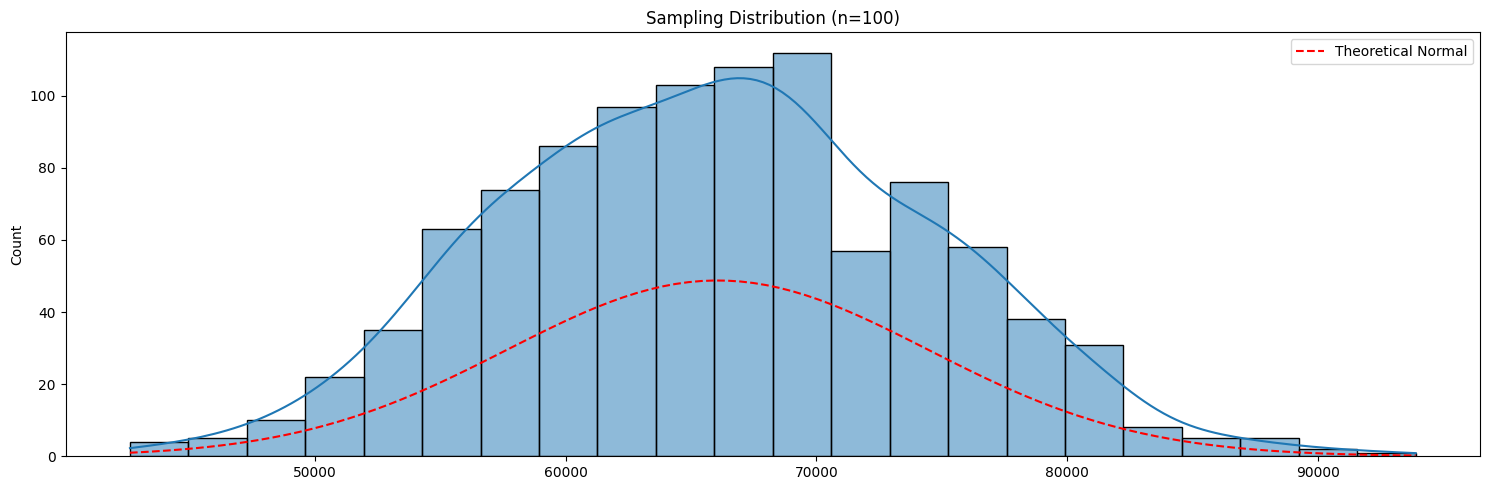

Sampling Distribution Statistics:
Mean of sample means: 66190.076
Population mean: 66060.421

Std of sample means: 2624.941
Expected std (σ/√n): 2651.404


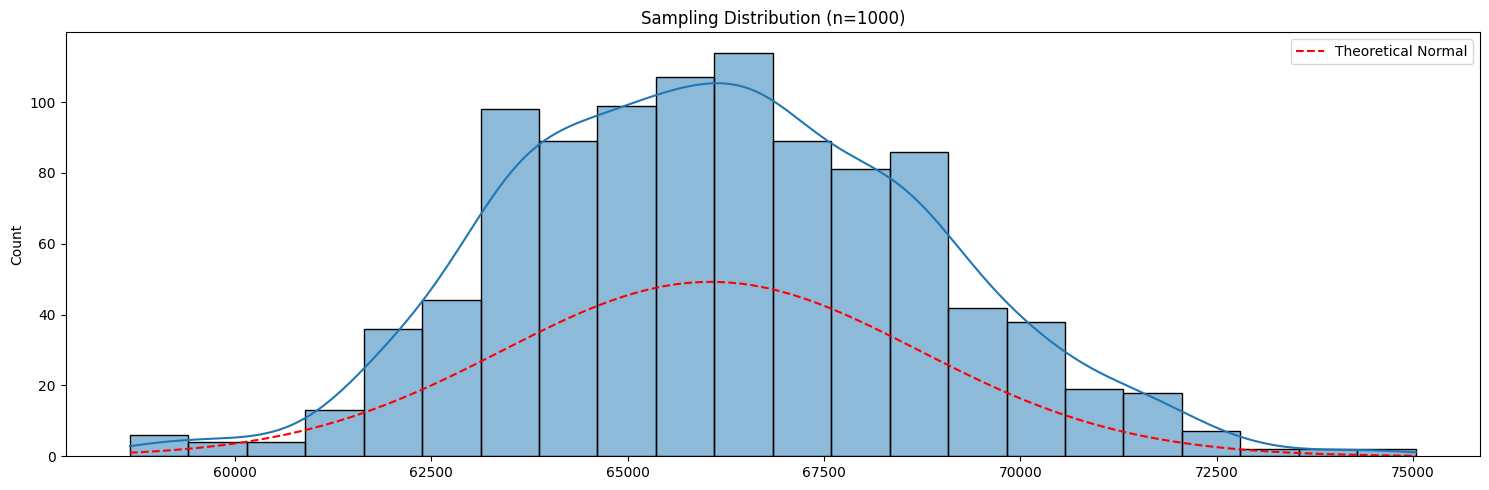

In [ ]:
# Central Limit Theorem application
def simulate_sampling_distribution(population, sample_size, n_samples=1000):
    """Generate sampling distribution of means.
    
    Parameters:
    population (array): Original population data
    sample_size (int): Size of each sample
    n_samples (int): Number of samples to draw
    
    Returns:
    array: Sample means
    """
    sample_means = np.array([np.mean(np.random.choice(population, size=sample_size)) 
                            for _ in range(n_samples)])
    return sample_means

def plot_sampling_distribution(population, sample_size, n_samples=1000):
    """Visualize sampling distribution with theoretical normal curve.
    
    Parameters:
    population (array): Original population data
    sample_size (int): Size of each sample
    n_samples (int): Number of samples to draw
    """
    # Get sample means
    sample_means = simulate_sampling_distribution(population, sample_size, n_samples)
    
    # Create plot
    fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))
    
    # Histogram of sample means
    sns.histplot(data=sample_means, kde=True, ax=ax1)
    ax1.set_title(f'Sampling Distribution (n={sample_size})')
    
    # Add theoretical normal 
    x = np.linspace(min(sample_means), max(sample_means), 100)
    pop_mean = np.mean(population)
    pop_std = np.std(population)
    theoretical_std = pop_std / np.sqrt(sample_size)
    theoretical = stats.norm.pdf(x, pop_mean, theoretical_std)
    ax1.plot(x, theoretical * len(sample_means) * (max(sample_means) - min(sample_means)) / 50,
             'r--', label='Theoretical Normal')
    ax1.legend()
    
    plt.tight_layout()
    
    # Print statistics
    print('Sampling Distribution Statistics:')
    print(f'Mean of sample means: {np.mean(sample_means):.3f}')
    print(f'Population mean: {pop_mean:.3f}')
    print(f'\nStd of sample means: {np.std(sample_means):.3f}')
    print(f'Expected std (σ/√n): {theoretical_std:.3f}')

# Load your data
# Assuming df_summed is already defined and contains the necessary columns

# Visualize Central Limit Theorem for the 'Total_AC' column with different sample sizes
sample_sizes = [30, 100, 1000]
for n in sample_sizes:
    plot_sampling_distribution(df_summed['Total_AC'].dropna().values, sample_size=n, n_samples=1000)
    plt.show()

# Result Interpretation
- **Law of Large Numbers demonstration:**
    - The Law of Large Numbers states that as the number of trials increases, the sample mean will tend to be closer to the population mean. In this case, the Law of Large Numbers is demonstrated by calculating the sample mean of Total_AC exceeding the threshold value of 90,000 for different sample sizes. As the sample size increases, the sample mean tends to be closer to the population mean, which is the probability of Total_AC exceeding the threshold value of 90,000.
- **Central Limit Theorem application:**
    - The Central Limit Theorem states that the sampling distribution of the sample mean will be approximately normally distributed, regardless of the population distribution, as the sample size increases. In this case, the Central Limit Theorem is applied by calculating the sample mean of Total_AC exceeding the threshold value of 90,000 for different sample sizes and plotting the sampling distribution. As the sample size increases, the sampling distribution tends to be closer to a normal distribution.

# 2.5 Regression Analysis (30 points)

- **Linear/Polynomial model selection (10 points)**
- **Model fitting and validation (15 points)**
- **Result interpretation and analysis (5 points)**

Cross-Validation Mean Squared Error: 0.4231124461061171
Cross-Validation R-squared: 0.9657363197190385
Test Set Mean Squared Error: 1.4847142440941279
Test Set R-squared: 0.9161636365335124


/home/remotejrg/Documents/Assigment-4/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


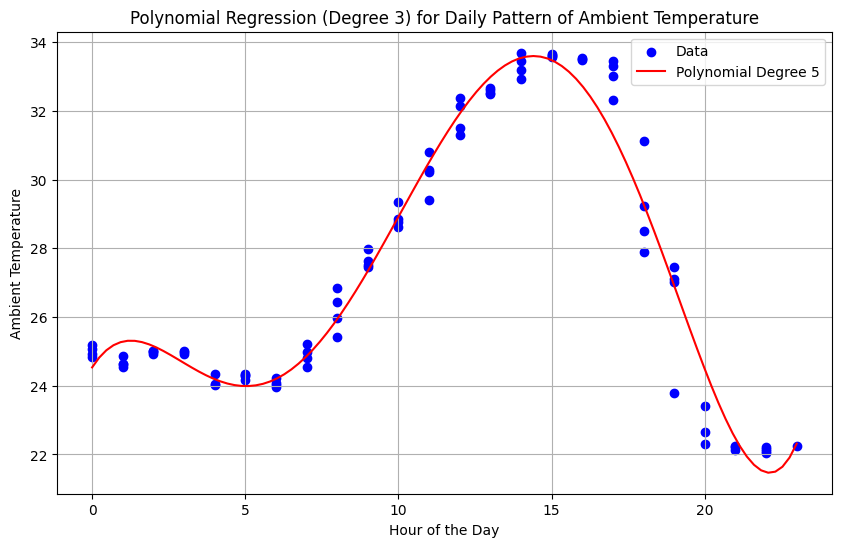

In [64]:
# Linear/Polynomial model selection
# Prepare the data
# Convert DATE_TIME to datetime format
df_summed['DATE_TIME'] = pd.to_datetime(df_summed['DATE_TIME'])

# Extract useful features from DATE_TIME
df_summed['Hour'] = df_summed['DATE_TIME'].dt.hour

# Filter data for a specific day (e.g., the first day in the dataset)
specific_day = df_summed[df_summed['DATE_TIME'].dt.date == df_summed['DATE_TIME'].dt.date.iloc[0]]

# Prepare the features and target variable
X = specific_day[['Hour']]
y = specific_day['AMBIENT_TEMPERATURE']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a polynomial regression model of degree 5
degree = 5
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Perform cross-validation
cv_scores = cross_val_score(poly_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_scores_r2 = cross_val_score(poly_model, X_train, y_train, cv=5, scoring='r2')

# Fit the model on the entire training set
poly_model.fit(X_train, y_train)

# Generate predictions on the test set
y_pred = poly_model.predict(X_test)

# Evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Cross-Validation Mean Squared Error: {-cv_scores.mean()}")
print(f"Cross-Validation R-squared: {cv_scores_r2.mean()}")
print(f"Test Set Mean Squared Error: {mse}")
print(f"Test Set R-squared: {r2}")

# Generate predictions for plotting
X_fit = np.linspace(0, 23, 100).reshape(-1, 1)  # Generate 100 points from 0 to 23 hours
y_fit = poly_model.predict(X_fit)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X, y, label='Data', color='blue')
plt.plot(X_fit, y_fit, label=f'Polynomial Degree {degree}', color='red')
plt.xlabel('Hour of the Day')
plt.ylabel('Ambient Temperature')
plt.title('Polynomial Regression (Degree 3) for Daily Pattern of Ambient Temperature')
plt.legend()
plt.grid()
plt.show()